## Quora Question-pair classification

This project idea is taken from the kaggle competition about building a prediction model that can identify whether a pair of questions on Quora is semantically same or not. If a question-pair can be answered with the same discussion threads, they are considered semantically similar. Currently Quora uses Random forest model for the task. We will implement a few different classifier and NLP techniques using the Quora quetion pair dataset provided for the kaggle challange. 

The training dataset is completely labeled with 404,290 rows and 6 columns. The columns are following: 

- question1, question2: columns containing question pair texts 
- qid1, qid2 : columns containg the ids of each questions
- id : the id of a training set question pair
- is_duplicate : the target column containing the labels for each row of data

In the test dataset, there is 1 column of test id for each question-pair and 2 text columns for the question pairs. 
<br><br>
<div>
<p> Steps to build the model:
   <ul>
    <li>Exploratory Data Analysis </li>
    <li>Data wrangling: Handle missing data, duplic rows, and outliers</li>
    <li>Basic feature engineering  </li>
    <li>TF-IDF encodings of the question pair texts</li>
    <li>Model selection and evaluation</li>
    <li>Model refinement and improving the performance</li>
    </ul>
</p>
</div>

In [1]:
# Import the important libraries/packages
import numpy as np
import pandas as pd
import re
import nltk
import seaborn as sns
import gensim
from matplotlib import pyplot as plt
%matplotlib inline

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")


C:\Users\Plabon\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# load the training dataset
train_data = pd.read_csv('D:\Downloads\Springboard Python\Data\\train.csv')


In [3]:
# load the test dataset 
test_data = pd.read_csv('D:\Downloads\Springboard Python\Data\\test.csv')


C:\Users\Plabon\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\IPython\core\interactiveshell.py:2714: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 1. EDA

### Training data analysis

#### 1.1 A few rows of the traning dataset ####

In [4]:
# first few rows of the training data
train_data.head()


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


#### 1.2 Columns of the training  data set ####

In [5]:
# columns of the training datas
train_data.columns


Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

**1.3 Size of the Datasets**

In [6]:
print("Size of the test data: ", test_data.shape)
print("Size of the train data: ", train_data.shape)


Size of the test data:  (3563475, 3)
Size of the train data:  (404290, 6)


**1.4 Data type of each columns and the Missing Data**

In [7]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [8]:
# Drop The missing value and duplicate rows
train_df = train_data.dropna()
train_df = train_df.drop_duplicates()

# Data type and info after dropping the na values
train_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 404287 entries, 0 to 404289
Data columns (total 6 columns):
id              404287 non-null int64
qid1            404287 non-null int64
qid2            404287 non-null int64
question1       404287 non-null object
question2       404287 non-null object
is_duplicate    404287 non-null int64
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


**1.5 Number of duplicate and non-duplicate questoion-pairs:**

In [9]:
train_df.groupby("is_duplicate")['id'].count()


is_duplicate
0    255024
1    149263
Name: id, dtype: int64

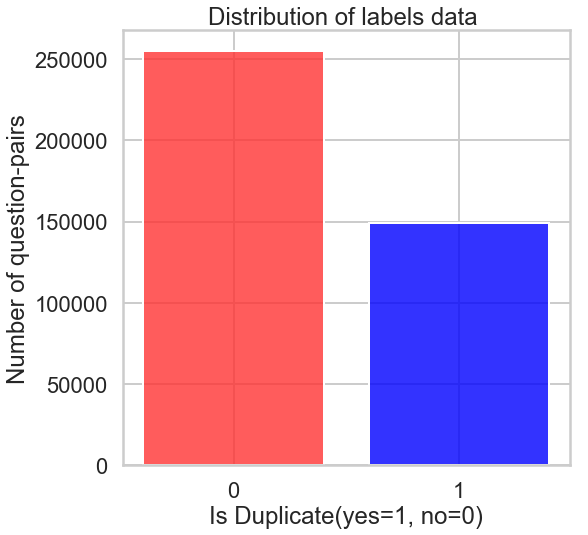

In [10]:
plt.figure(figsize=(8, 8))
plt.bar([0, 1], train_df.groupby("is_duplicate")['id'].count(),
        color=[(1, 0.2, 0.2, 0.8), ((0, 0, 1, 0.8))])
plt.xticks([0, 1])
plt.xlabel('Is Duplicate(yes=1, no=0)')
plt.ylabel('Number of question-pairs')
plt.title("Distribution of labels data ")
plt.show()


### 1.6  'question1' Text Length insights ###

#### 1.6.1 Number of characters in the  questions in question1 column ####

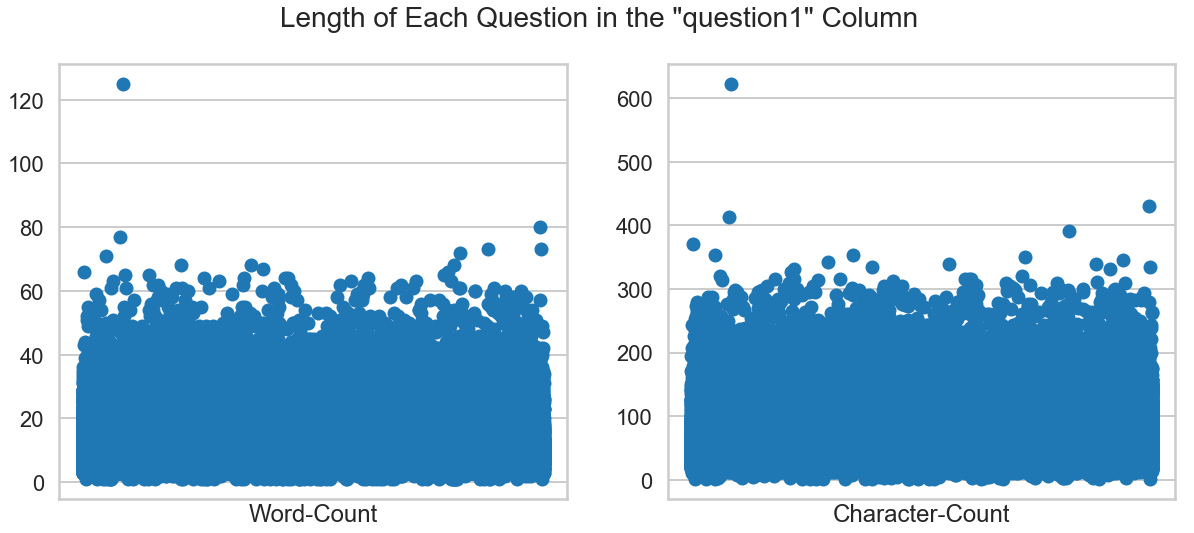

In [11]:
import matplotlib.gridspec as gridspec
sns.set_style('whitegrid')

# set the figure size and add a title
fig = plt.figure(figsize=(20, 8))
fig.suptitle('Length of Each Question in the "question1" Column', size=28)
fig.set_label(s='Question1')

# create the figure grids
gs = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[2, 2])

# plot the boxplot of the question1 character length
ax1 = plt.subplot(gs[0])
plt.scatter(np.arange(len(train_df.question1)),
            train_df.question1.str.split().str.len())
# plt.yticks(range(0,130,40))
plt.xticks([])
plt.xlabel('Word-Count')
# plot the scatter plot in the second grid
ax2 = plt.subplot(gs[1])
plt.scatter(np.arange(len(train_df.question1)), train_df.question1.str.len())
# plt.yticks(range(0,640,100))
plt.xlabel('Character-Count')
plt.xticks([])
plt.show()


#### 1.6.2 Text of Some Short Questions and Longest Question in the 'question1' Column

In [12]:
print('Some of the Short Questions in "question1" column')
print('--------------------------------------------------------')
print(train_df.question1[train_df.question1.str.split().str.len() < 3][:10])
print('\n\nLongest Question in the "question1" column')
print('--------------------------------------------------------')
print(train_df.question1[train_df.question1.str.len() == max(train_df.question1.str.len())].tolist())


Some of the Short Questions in "question1" column
--------------------------------------------------------
3306                        .
8361     Cloud certification?
13016                       ?
17465     Female ejaculation?
17682                 deleted
20794                       ?
23305                 deleted
23884                      HH
25228                   What?
25315                 deleted
Name: question1, dtype: object


Longest Question in the "question1" column
--------------------------------------------------------
['Like everyone else (here in U.S), I work with a group of people I see and interact with every day. As a human rights advocate and Lesbian, my views are liberal and I by no means preach my beliefs in my work place. However, I want to know, when is it OK to state your opinions on an issue. For example, if someone mentions that their next door neighbor, who happens to be a 12 year old boy, was playing with dolls and that "this is going down the wrong road a

### 1.7  'question2' Text Length insights

#### 1.7.1 Number of the characters in the questions in question2 columns ###

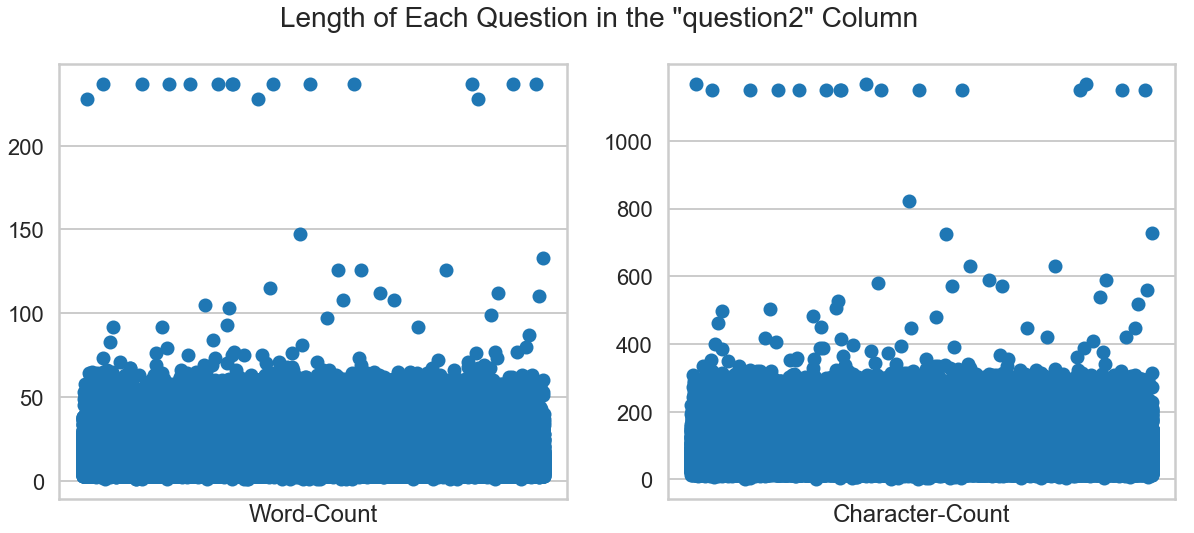

In [13]:
# set the figure size and add a title
fig = plt.figure(figsize=(20, 8))
fig.suptitle('Length of Each Question in the "question2" Column', size=28)
fig.set_label(s='Question2')

# create the figure grids
gs = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[2, 2])

# plot the boxplot of the question1 character length
ax1 = plt.subplot(gs[0])
plt.scatter(np.arange(len(train_df.question2)),
            train_df.question2.str.split().str.len())
plt.yticks(range(0, 250, 50))
plt.xlabel('Word-Count')
plt.xticks([])

# plot the scatter plot in the second grid
ax2 = plt.subplot(gs[1])
plt.scatter(np.arange(len(train_df.question2)), train_df.question2.str.len())
plt.yticks(range(0, 1200, 200))
plt.xticks([])
plt.xlabel('Character-Count')
plt.show()


### 1.7.2 Text of Some Short and the Longest Question in the 'Question2' Column

In [14]:
print('Some of the Short Questions in "question2" column')
print('--------------------------------------------------------')
print(train_df.question2[train_df.question2.str.split().str.len() < 3][:10])
print('\n\nLongest Question in the "question2" column')
print('--------------------------------------------------------')
print(train_df.question2[train_df.question2.str.len() == max(train_df.question2.str.len())].tolist())


Some of the Short Questions in "question2" column
--------------------------------------------------------
12010          Uri attack?
16479            Big data?
16619       Tyrone st.ours
20072               …………..
24120     What's humanity?
29155    Moderate talkers?
29345     Surgical strike?
44625     What's infinity?
46596                What?
47056                    ?
Name: question2, dtype: object


Longest Question in the "question2" column
--------------------------------------------------------
['I have been married almost 15 years. We have two children, 11 and 8. My childhood was horrible, seven years of sexual, physical, and mental/emotional abuse followed by instability and low self esteem issues as a teen. My husband met me after I began dealing with my childhood and knew all about my issues. He knew what would end our marriage, yet he did it and lied about it multiple times. I was pregnant and did not leave. We tried to make it work. We had another child. We have been th

### 1.9 Most Common words in the question-pairs 

In [15]:
# remove all the punctuation and noises from quetion1 text
text1 = " ".join(train_data['question1'].fillna("")).lower()
text1 = gensim.parsing.strip_punctuation2(text1)
text1 = gensim.parsing.strip_short(text1, minsize=2)

# remove all the punctuation and noises from question2 text
text2 = " ".join(train_data["question2"].fillna("")).lower()
text2 = gensim.parsing.strip_punctuation2(text2)
text2 = gensim.parsing.strip_short(text2, minsize=2)


In [16]:
# importing wordcloud module
from wordcloud import WordCloud

# generate a WordCloud for question1
stopwords = nltk.corpus.stopwords.words('english')
question1_wc = WordCloud(width=800, height=800,
                         background_color='white',
                         stopwords=stopwords,
                         min_font_size=10,
                         contour_width=3,
                         contour_color='steelblue').generate(text1)

question2_wc = WordCloud(width=800, height=800,
                         background_color='white',
                         stopwords=stopwords,
                         min_font_size=10,
                         contour_width=3,
                         contour_color='steelblue').generate(text2)


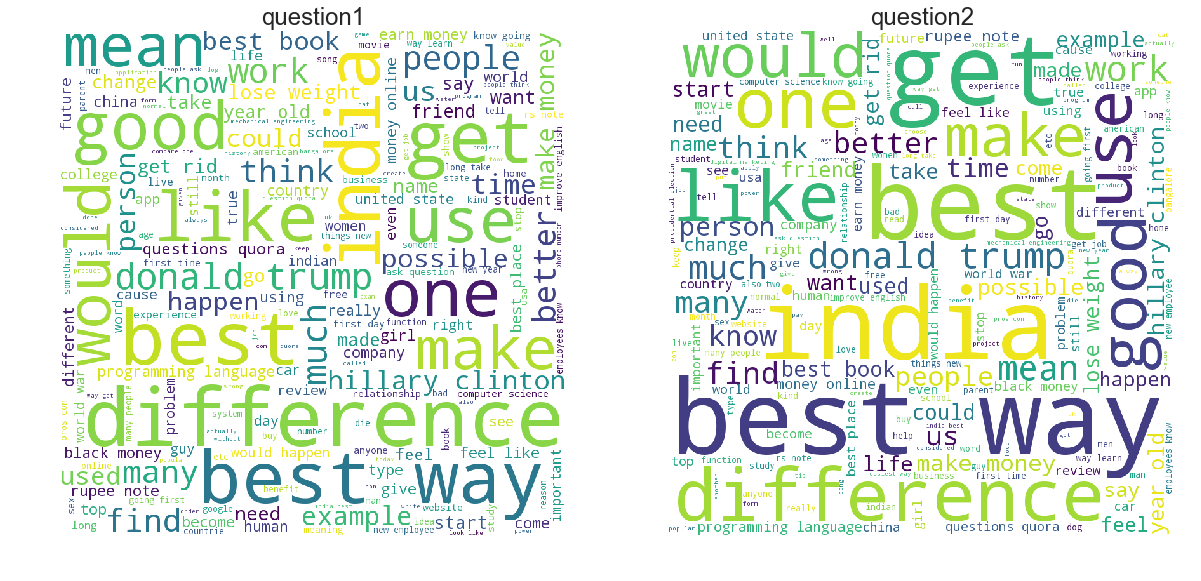

In [17]:
# create the figure grids
plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(ncols=2, nrows=1)

# plot the WordCloud images
ax1 = plt.subplot(gs[0])
plt.imshow(question1_wc)
plt.axis("off")
plt.title('question1')

ax2 = plt.subplot(gs[1])
plt.imshow(question2_wc)
plt.axis("off")
plt.title('question2')
plt.show()


## 2. Text Preprocessing and Feature Engineering

### 2.1 Text Processors 

All text column need to be combined row-wise before vectorizing the data. For a better result, noisy data such as word counts outliers, character count outliers,  foreign characters, punctuations need to be removed before tokenizing and vectorizing the text data. combined_Text will combine all the text data row-wise and preProcessText functino will perform the remaining text processing.

In [18]:
def combined_Text(df, to_combine=['question1', 'question2']):
    """ Converts all text in each row of data_frame to single vector """
    # Data frame with the text columns that are in the df
    text_data = df[to_combine]
    # Join all text items in a row that have a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)


In [19]:
def preProcessText(text):
    """ This function takes a text or list of text as its input
        and returns a processed text.
        1. Change the string to lower case
        2. Remove non utf-8 characters
        3. Remove common stopwords
        4. Remove all the punctuation2
        5. Remove multiple whitespaces
        6. Remove all the single characters or numbers
        6. Stem the text"""
    # Convert text to lower
    text = text.lower()
    # Removing all the non-alphanumeric characters
    text = gensim.parsing.preprocessing.strip_non_alphanum(text)
    # Removing all the stopwords
    text = gensim.parsing.preprocessing.remove_stopwords(text)
    # Strip multiple whitespaces
    text = gensim.corpora.textcorpus.strip_multiple_whitespaces(text)
    # Strip single characters and numbers
    text = gensim.parsing.preprocessing.strip_short(text, minsize=2)
    # Stemming: gensim.parsing.PorterStem() or
    return gensim.parsing.preprocessing.stem_text(text)


### 2.2 Feature engineering 
The given features are the question text pairs. After the text processing, many words, alphanumeric characters, and other characters will be removed, and the remaining text will be converted to the lowercase. It may result in significant information loss. That is why, it is necesary to add extra features such as number of words in a question, numbers of character in the questions.

In [20]:
def preProcess_datframe(data):
    """ adds new features to the dataset e.g. character length
    and the number of words in each question."""
    data['char_len1'] = data.question1.str.len()
    data['char_len2'] = data.question2.str.len()
    data['wlen1'] = data.question1.str.split().str.len()
    data['wlen2'] = data.question2.apply(lambda x: len(x.split()))
    data['question1'] = data.question1.apply(lambda x: preProcessText(x))
    data['question2'] = data.question2.apply(lambda x: preProcessText(x))
    return data


### 2.3 preprocess and add featurs to the training data
- Remove the noises from the dataset(i.e. remove rows with questions containing less than 3 words)
- Add word count and character count features
- Filter out the rows with Incorrect labels
- Seperate the features and the label to build the a model 

In [21]:
# remove outliers from the train data
train_df = train_df[(train_df.question1.str.split().str.len() > 2)]
train_df = train_df[(train_df.question2.str.split().str.len() > 2)]

# add word count and character count features to the train dataset
X = preProcess_datframe(train_df[['question1', 'question2']].dropna())

# remove incorretly labeled data
inconsistent_labels = (X.question1 == X.question2) > train_df.dropna()['is_duplicate']
X = X[~inconsistent_labels]
y = train_df[~inconsistent_labels]['is_duplicate']


### 2.1 Seperate a hold-out dataset to test the model ###

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=45)


## 3. Training Models

### 3.1 Create a pipeline

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline

get_text_data = FunctionTransformer(combined_Text, validate=False)
get_num_data = FunctionTransformer(lambda x: x[X.columns.tolist()[2:]], validate=False)

pl = Pipeline([
    ('uninon', FeatureUnion([
                ('numeric_features', Pipeline([
                    ('selector', get_num_data)
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', TfidfVectorizer())
                ]))
             ])),
    ('clf', MultinomialNB())])


### 3.2 Training the Model and Evaluation on Holdout Dataset

In [24]:
# fit the pipelined model to the train data
pl.fit(X_train, y_train)
y_pred_proba = pl.predict_proba(X_test)


In [25]:
from sklearn.metrics import log_loss
log_loss(y_test, y_pred_proba)


0.5385162984618226

## 4. Evaluation on the test data set

###  4.1 Test Data Cleaning

In [26]:
# find the index of the valid question pairs
valid_ids = [type(x) == int for x in test_data.test_id]


In [27]:
# remove all the invalid question pairs from the test dataset
test_df = test_data[valid_ids].drop_duplicates()


### 4.2 Pre-processing the Question-pair Texts of Test Dataset

In [28]:
# add the extra features to the dataset
test_X = preProcess_datframe(test_df[['question1', 'question2']].fillna(" "))


### 4.3 Predicting probabilities and Evaluating on Kaggle

In [29]:
y_pred_proba_test = pl.predict_proba(test_X)

In [30]:
# save the data in the csv file for kaggle submission
submission_file = pd.DataFrame({'test_id': range(len(y_pred_proba_test))})
submission_file['is_duplicate'] = y_pred_proba_test[:, 1]


In [31]:
# save to a csv file for evaluation
submission_file.to_csv('submission.csv', index=False)


***Kaggle Competition Score***
- Public Score: 0.43864
- Private Score: 0.44003

## 5.  Model Refining

### 5.1 Find the best alpha for the classifier

In [32]:
from sklearn.feature_extraction.text import CountVectorizer


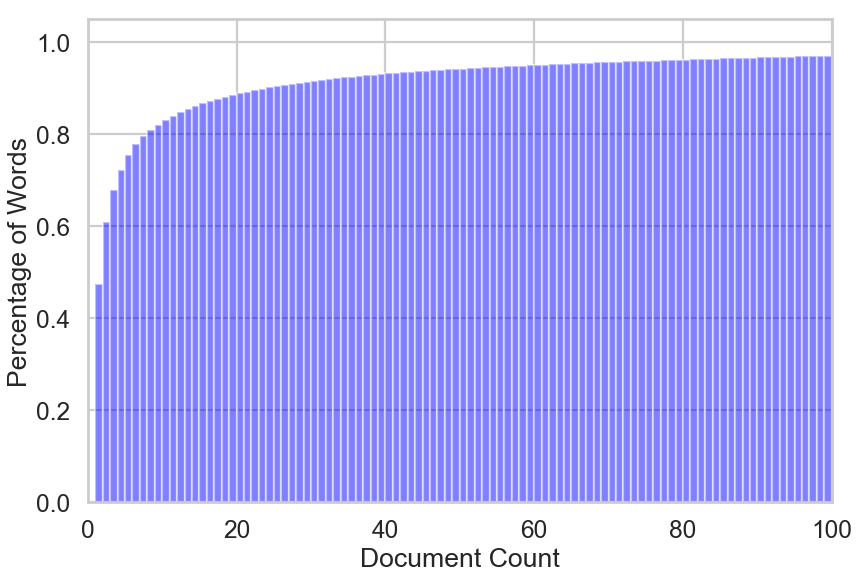

In [33]:
# Vectorize the whole question-pair text-documents and count the tokens
X_csc = CountVectorizer().fit_transform(X['question1'] + " " + X['question2']).tocsc()

# Count the document frequency of the words
doc_frequency = np.sum((X_csc > 0), axis=0).tolist()[0]


# plot the cumulative document frequency of the words
# to find minimum and maximum values for min_df
plt.figure(figsize=(12, 8), dpi=80)
plt.hist(np.array(doc_frequency), bins=np.arange(300), cumulative=True,
         normed=True, color='blue', edgecolor='w', alpha=0.5)
plt.xlabel('Document Count')
plt.ylabel('Percentage of Words')
plt.xlim(0, 100)
plt.show()


## 6.  Refine the Model using n-gram and best parameter for Tf-idf vectorizer ##

### 6.1 Find the Best min_df for Tf-idf Vectorizer

In [34]:
logloss_count = None
logloss_min = np.inf

# the grid of parameters to search over
min_dfs = np.array([1, 5, 10, 15, 20])
alphas = [0.001, 0.01, 0.1, 1, 5]

# Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
maxscore = -np.inf

for min_df in min_dfs:
    for alpha in alphas:
        pl = Pipeline([
            ('uninon', FeatureUnion([
                    ('numeric_features', Pipeline([
                        ('selector', get_num_data)
                    ])),
                    ('text_features', Pipeline([
                        ('selector', get_text_data),
                        ('vectorizer', TfidfVectorizer(min_df=min_df, ngram_range=(1, 2)))
                    ]))
                 ])),
            ('clf', MultinomialNB(alpha=alpha))])
        pl.fit(X_train, y_train)
        y_proba = pl.predict_proba(X_test)
        logloss_count = log_loss(y_test, y_proba)
        if logloss_count < logloss_min:
            logloss_min = logloss_count
            best_min_df = min_df
            best_alpha = alpha


In [36]:
print('Best min_df : {:.2f}'.format(best_min_df))
print('Best alpha : {:.2f}'.format(best_alpha))

Best min_df : 1.00
Best alpha : 0.10


### 6.2  Build a Pipeline with Best Parameters and Bigram

In [37]:
pl_n_gram = Pipeline([
    ('uninon', FeatureUnion([
                ('numeric_features', Pipeline([
                    ('selector', get_num_data)
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', TfidfVectorizer(min_df=best_min_df, ngram_range=(1, 2)))
                ]))
             ])),
    ('clf', MultinomialNB(alpha=best_alpha))])


In [38]:
# fit the pipelined model to the train data
pl_n_gram.fit(X_train, y_train)


Pipeline(memory=None,
     steps=[('uninon', FeatureUnion(n_jobs=None,
       transformer_list=[('numeric_features', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function <lambda> at 0x000001698171A268>, inv_kw_args=None,
          inverse_func=Non...      transformer_weights=None)), ('clf', MultinomialNB(alpha=1, class_prior=None, fit_prior=True))])

In [39]:
# Prediction probability of the Testing dataset with the improved parameters 
test_y_n_gram = pl_n_gram.predict_proba(test_X)


In [40]:
submission_file['is_duplicate'] = test_y_n_gram[:, 1]
submission_file.to_csv('submission_n_gram.csv', index=False)


***Updated Kaggle Competition Score***
- Public Score: 0.430
- Private Score: 0.431


### 6.4   Train the Model on Entire Train Dataset and Evaluate on Test Dataset

In [41]:
# fit the pipelined model to the train data
pl_n_gram.fit(X, y)


Pipeline(memory=None,
     steps=[('uninon', FeatureUnion(n_jobs=None,
       transformer_list=[('numeric_features', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function <lambda> at 0x000001698171A268>, inv_kw_args=None,
          inverse_func=Non...      transformer_weights=None)), ('clf', MultinomialNB(alpha=1, class_prior=None, fit_prior=True))])

In [42]:
test_y_n_gram = pl_n_gram.predict_proba(test_X)


In [43]:
submission_file['is_duplicate'] = test_y_n_gram[:, 1]
submission_file.to_csv('submission_n_grams.csv', index=False)

***Further Updated Kaggle Competition Score***
- Public Score: 0.404
- Private Score: 0.405

## 7. Refine Model Using Doc2Vec with Default (untuned)  Parameters 

In [44]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from scipy.spatial.distance import cosine, euclidean


In [45]:
# load previously trained doc2vec model with default parameter. 
d2v = Doc2Vec.load('doc2vec_quora')


In [46]:
# vectorize training data
X_question1_vectors = X.question1.apply(d2v.infer_vector)
X_question2_vectors = X.question2.apply(d2v.infer_vector)

# vectorize test data
test_question1_vectors = test_X.question1.apply(d2v.infer_vector)
test_question2_vectors = test_X.question2.apply(d2v.infer_vector)


In [47]:
# cosine and euclidean features of the training dataset
X['cos'] = [cosine(X_question1_vectors[i], X_question2_vectors[i])
            for i in X_question1_vectors.index]

X['euclid'] = [euclidean(X_question1_vectors[i], X_question2_vectors[i])
               for i in X_question1_vectors.index]


In [48]:
# consine and euclidead distance features of the testdata
test_X['cos'] = [cosine(test_question1_vectors[i], test_question2_vectors[i])
                 for i in test_question1_vectors.index]

test_X['euclid'] = [euclidean(test_question1_vectors[i], test_question2_vectors[i])
                    for i in test_question1_vectors.index]


In [49]:
# Improved pipeline with for d2v model
pl_d2v = Pipeline([
    ('uninon', FeatureUnion([
                ('numeric_features', Pipeline([
                    ('selector', get_num_data)
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', TfidfVectorizer(min_df=best_min_df, ngram_range=(1,2)))
                ]))
             ])),
    ('clf', MultinomialNB(alpha=best_alpha))])


In [50]:
# train the pipeline on training dataset 
pl_d2v.fit(X, y)

# predict the probablity on the test dataset
y_d2v = pl_d2v.predict_proba(test_X)


In [51]:
# save the prediction probability data in the submission file 
submission_file['is_duplicate'] = y_d2v[:, 1]
submission_file.to_csv('submission_d2v.csv', index=False)


***Updated Kaggle Competition Score with Doc2vec***
- Public Score: 0.403
- Private Score: 0.404

## 8. Refine the model further with Doc2vec with Tuned Parameter

In [52]:
# Train a Doc2Vec Model over the training data with tuned parameters
documents_q1 = X.question1.tolist()
documents_q1 = [TaggedDocument(doc, [i]) for i, doc in enumerate(documents_q1)]
d2v_model_q1 = Doc2Vec(documents_q1,
                       vector_size=300,
                       window=10, min_count=2,
                       workers=8, epochs=20)
d2v_model_q1.save('doc2vec_quora_tuned')


In [53]:
documents_q2 = X.question2.tolist()
documents_q2 = [TaggedDocument(doc, [i]) for i, doc in enumerate(documents_q2)]
d2v_model_q2 = Doc2Vec(documents_q2,
                       vector_size=300,
                       window=10,
                       min_count=2,
                       workers=8,
                       epochs=20)


In [54]:
# vectorize training data
X_question1_vectors = d2v_model_q1.docvecs.vectors_docs
X_question2_vectors = d2v_model_q2.docvecs.vectors_docs


In [55]:
# train the test dataset question1
documents_t1 = test_X.question1.tolist()
documents_t1 = [TaggedDocument(doc, [i]) for i, doc in enumerate(documents_t1)]
d2v_model_t1 = Doc2Vec(documents_t1,
                       vector_size=300,
                       window=10,
                       min_count=2,
                       workers=8,
                       epochs=20)


In [56]:
#train test dataset question2
documents_t2 = test_X.question2.tolist()
documents_t2 = [TaggedDocument(doc, [i]) for i, doc in enumerate(documents_t2)]
d2v_model_t2 = Doc2Vec(documents_t2,
                       vector_size=300,
                       window=10,
                       min_count=2,
                       workers=8,
                       epochs=20)


In [57]:
# vectorize test data
test_question1_vectors = d2v_model_t1.docvecs.vectors_docs
test_question2_vectors = d2v_model_t2.docvecs.vectors_docs


In [58]:
# add the cosine and euclidean distance features to the train datasets 
X['cos'] = [cosine(X_question1_vectors[i, :], X_question2_vectors[i, :])
            for i in range(X_question1_vectors.shape[0])]
X['euclid'] = [euclidean(X_question1_vectors[i, :], X_question2_vectors[i, :])
               for i in range(X_question1_vectors.shape[0])]

# add the cosine and euclidean distance features to the test datasets 
test_X['cos'] = [cosine(test_question1_vectors[i, :], test_question2_vectors[i, :])
                 for i in range(test_question1_vectors.shape[0])]
test_X['euclid'] = [euclidean(test_question1_vectors[i, :], test_question2_vectors[i, :])
                    for i in range(test_question1_vectors.shape[0])]


In [59]:
# train the pipeline over the training data
pl_d2v.fit(X, y)

# predict the probability on the test dataset
y_d2v_model = pl_d2v.predict_proba(test_X)


In [60]:
# prepare the submission file for kaggle
submission_file['is_duplicate'] = y_d2v_model[:, 1]
submission_file.to_csv('submission_d2v_test.csv', index=False)


***Updated Kaggle Competition Score with Doc2vec***
- Public Score: 0.398</li>
- Private Score: 0.399</li>


## 9. Train the model with a Pretrained Doc2vec on wikipidea data

In [61]:
# load pretrained model on wikipedia corpus
d2v_en_wiki = Doc2Vec.load('doc2vec.bin')


In [62]:
# vectorize training data
X_question1_vectors = train_df[~inconsistent_labels].question1.apply(
    lambda x: d2v_en_wiki.infer_vector(x, epochs=10))
X_question2_vectors = train_df[~inconsistent_labels].question2.apply(
    lambda x: d2v_en_wiki.infer_vector(x, epochs=10))


In [63]:
# vectorize training data
X_question1_vectors = X.question1.apply(
    lambda x: d2v_en_wiki.infer_vector(x, epochs=20))
X_question2_vectors = X.question2.apply(
    lambda x: d2v_en_wiki.infer_vector(x, epochs=20))


In [64]:
# vectorize test data
test_df = test_df.fillna(" ")
test_question1_vectors = test_X.question1.apply(
    lambda x: d2v_en_wiki.infer_vector(x, epochs=20))
test_question2_vectors = test_X.question2.apply(
    lambda x: d2v_en_wiki.infer_vector(x, epochs=20))


In [65]:
# add the cosine and euclidean distance features to the datasets 
X['cos'] = [cosine(X_question1_vectors[i], X_question2_vectors[i])
            for i in X_question1_vectors.index]
X['euclid'] = [euclidean(X_question1_vectors[i], X_question2_vectors[i])
               for i in X_question1_vectors.index]

# add the cosine and euclidean distance features to the test datasets 
test_X['cos'] = [cosine(test_question1_vectors[i], test_question2_vectors[i])
                 for i in test_question1_vectors.index]
test_X['euclid'] = [euclidean(test_question1_vectors[i], test_question2_vectors[i])
                    for i in test_question1_vectors.index]


In [66]:
# Improved pipeline with for d2v model
pl_d2v_model = Pipeline([
    ('uninon', FeatureUnion([
                ('numeric_features', Pipeline([
                    ('selector', get_num_data)
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', TfidfVectorizer(min_df=best_min_df, ngram_range=(1,2)))
                ]))
             ])),
    ('clf', MultinomialNB(alpha=best_alpha))])


In [67]:
# train the pipeline over the training data
pl_d2v_model.fit(X, y)

# predict the probability on the test dataset
y_d2v_model = pl_d2v_model.predict_proba(test_X)


In [68]:
# prepare the submission file for kaggle
submission_file['is_duplicate'] = y_d2v_model[:, 1]
submission_file.to_csv('submission_d2v_wiki.csv', index=False)


***Updated Kaggle Competition Score with Doc2vec***
- Public Score: 0.404
- Private Score: 0.405


## 10. Experiments with different classifiers ##

Naive bayes classifier is a simple and efficient classifier, but may not produce the best result. Currently quora uses random forest classifier for the duplicate detection. Here we will experiment with a few other classifier using the pretrained doc2vec features only.

### 10.1 MultinomialNB 

In [69]:
# create 2D positive matrices for traning data
new_X = np.concatenate((X_question1_vectors - X_question1_vectors.min(),
                        X_question2_vectors - X_question2_vectors.min()),
                       axis=1)
# create 2D positive matrices for test data
new_test_X = np.concatenate((test_question1_vectors - test_question1_vectors.min(),
                             test_question2_vectors - test_question2_vectors.min()),
                            axis=1)


In [70]:
# Multinomial Naive Bayes model
nb_model = MultinomialNB(alpha=best_alpha)
nb_model.fit(new_X, y )


In [71]:
# calculate prediction probability
y_proba_nb  = nb_model.predict_proba(new_test_X)


In [72]:
# prepare the submission file for kaggle
submission_file['is_duplicate'] = y_proba_nb[:, 1]
submission_file.to_csv('submission_nb.csv', index=False)


***Kaggle Evaluation Score***
- Public Score: 0.560
- Private Score: 0.561


### 10.2 Logitic Regression Classifier ###

In [73]:
from sklearn.linear_model import LogisticRegressionCV


In [74]:
# initialize a logistic regression classifier
reg = LogisticRegressionCV(cv=5, Cs=np.logspace(-1, 1, 5), random_state=42)


In [75]:
# create 2d matrices for the training 
new_X = np.concatenate((np.array(X_question1_vectors.tolist()),
                        np.array(X_question2_vectors.tolist())),
                       axis=1)
# create 2d matrices for the training
new_test_X = np.concatenate((np.array(test_question1_vectors.tolist()),
                             np.array(test_question2_vectors.tolist())),
                            axis=1)


In [76]:
# train the classification
reg.fit(new_X, y)


In [77]:
# calculate the prediction probability
y_proba_reg = reg.predict_proba(new_test_X)


In [78]:
# prepare the submission file for kaggle
submission_file['is_duplicate'] = y_proba_svm[:, 1]
submission_file.to_csv('submission_logit.csv', index=False)


***Kaggle Evaluation Score***
- Public Score: 0.541
- Private Score: 0.542

### 10.3 Support Vectore Machine

In [79]:
from sklearn.svm import SVC


In [80]:
# initializa a svm classifier
svm_clf = SVC(C=10, gamma=0.001, probability=True)


In [81]:
# select a random subset of the data to train the classifier
np.random.seed(45)
row_no = np.random.choice(len(new_X), size=15000, replace=False)
seleceted_X = new_X[row_no, :]
seleceted_y = y.iloc[row_no]


In [82]:
# train the classifier
svm_clf.fit(seleceted_X, seleceted_y)


In [83]:
# calculate the prediction probability
y_proba_svm = svm_clf.predict_proba(new_test_X)


In [84]:
# prepare the submission file for kaggle
submission_file['is_duplicate'] = y_proba_svm[:, 1]
submission_file.to_csv('submission_svm.csv', index=False)


***Kaggle Evaluation Score***
- Public Score: 0.550
- Private Score: 0.551

### 9. Recommendations

This model is built on the basic Naive Base classifier with very minimal parameter tuning due to the time constraints. Further, parameter tuning with cross validation of different folding of the training data set would definitely improve the model. Besides, this model only uses a few features such as the text of the quetions, word counts, character counts, and vector space distances. It also ignores the case of the characters, foreign characters, and special characters, which may casuse a potential information loss.
For future experiment some recommended steps are following: 

- Correct misspelled words, replace abbreviation with the complete words
- Further correction of the labeling to minimize the errors
- Special characters count, word share ratio, capitalization count may be added as possible features
- Besides cosine and euclidean distances, other distance features can be added too
- Fuzzy ratio features may also improve the prediction probability
- Deep learning implementation such as word2vec, Recurrent neural networks etc. are left for further experiment